# Toronto Neighbourhood Segementation
## Author: Rahul Kulkarni

Let's read the cleaned data into a dataframe.

In [48]:
import pandas as pd
toronto = pd.read_csv('../input/clean-toronto/Clean_Toronto.csv')
toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.761124,-79.324059
1,M4A,North York,Victoria Village,43.732658,-79.311189
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.716516,-79.442261
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.653482,-79.383935


For our intial analysis we will consider our first neighbourhood, Parkwoods.

In [49]:
toronto['Neighbourhood'][0]

'Parkwoods'

Here we are generating the URL which will be used to communicate with the foursquare api and collect information about the nearby venues.

In [50]:
neighbourhood,latitude,longitude = toronto['Neighbourhood'][0],toronto['Latitude'][0],toronto['Longitude'][0]
url = 'https://api.foursquare.com/v2/venues/explore?client_id=BQ0DFXWNEE1TBLTWFUHHBXGBVD4A4SXYHZ2TLM4X5CVAVTC0&client_secret=R4JFL3NR3LFJIHMH5B5SZZVOKEIPHH03I25WRVTN3UZDM4IG&v=20201128&limit=100&ll='
ll = str(latitude)+','+str(longitude)
url += ll

Now we will contact the API and collect information about the venues near Parkwoods. We will eventually convert the data into a dataframe.

In [51]:
import requests
from pandas import json_normalize
results = requests.get(url).json()
parkwoods  = json_normalize(results['response']['groups'][0]['items'])
properties = ['venue.id','venue.name','venue.location.lat','venue.location.lng','venue.categories']
parkwoods = parkwoods[properties]
for i in parkwoods.index:
        parkwoods.loc[i,'venue.categories'] = parkwoods['venue.categories'][i][0]['name']
parkwoods.columns = ['ID','Name','Lat','Long','Category']
parkwoods['Neighbourhood'] = 'Parkwoods'
parkwoods.head()

,ID,Name,Lat,Long,Category,Neighbourhood
0,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,Parkwoods
1,4b804461f964a520876230e3,Johnny's Hamburgers,43.774833,-79.322365,Burger Joint,Parkwoods
2,4b8ec91af964a520053733e3,Graydon Hall Manor,43.763923,-79.342961,Event Space,Parkwoods
3,57e286f2498e43d84d92d34a,Tim Hortons,43.760668,-79.326368,Café,Parkwoods
4,4bc4a69cb492d13a6554aa60,Tasty Shawarma & Falafel,43.776126,-79.318424,Falafel Restaurant,Parkwoods


Now we will use OneHotEncoding to convert the categories into numerical data, which will help us in clustering and further analysis.

In [52]:
onc = pd.get_dummies(parkwoods['Category'])
parkwoods = parkwoods.join(onc)
parkwoods.head()

,ID,Name,Lat,Long,Category,Neighbourhood,American Restaurant,Bagel Shop,Bakery,Breakfast Spot,...,Salad Place,Salon / Barbershop,Seafood Restaurant,Shopping Mall,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Toy / Game Store,Vietnamese Restaurant
0,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,Parkwoods,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4b804461f964a520876230e3,Johnny's Hamburgers,43.774833,-79.322365,Burger Joint,Parkwoods,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4b8ec91af964a520053733e3,Graydon Hall Manor,43.763923,-79.342961,Event Space,Parkwoods,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57e286f2498e43d84d92d34a,Tim Hortons,43.760668,-79.326368,Café,Parkwoods,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4bc4a69cb492d13a6554aa60,Tasty Shawarma & Falafel,43.776126,-79.318424,Falafel Restaurant,Parkwoods,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
'There are {} different categories of venues in Parkwoods'.format(onc.shape[1])

'There are 56 different categories of venues in Parkwoods'

Let's look at the top 5 categories of venues near Parkwoods.

In [54]:
parkwoods_grouped = parkwoods.groupby(['Neighbourhood']).mean()
parkwoods_grouped.drop(['Lat','Long'],axis=1,inplace=True)
parkwoods_grouped = parkwoods_grouped.transpose()
parkwoods_grouped.sort_values(by=['Parkwoods'],ascending=False).head()

Neighbourhood,Parkwoods
Middle Eastern Restaurant,0.09
Coffee Shop,0.05
Chinese Restaurant,0.05
Japanese Restaurant,0.04
Italian Restaurant,0.03


Now we will do the same analysis on all the neighboirhoods.

In [55]:
venues = pd.DataFrame({'ID':[],'Name':[],'Lat':[],'Long':[],'Category':[]})
for lat,long,nei in zip(toronto['Latitude'],toronto['Longitude'],toronto['Neighbourhood']):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id=BQ0DFXWNEE1TBLTWFUHHBXGBVD4A4SXYHZ2TLM4X5CVAVTC0&client_secret=R4JFL3NR3LFJIHMH5B5SZZVOKEIPHH03I25WRVTN3UZDM4IG&v=20201128&limit=100&ll='
    ll = str(lat)+','+str(long)
    url += ll
    # ---------------------------------------------------------
    results = requests.get(url).json()
    neighbourhood  = json_normalize(results['response']['groups'][0]['items'])
    properties = ['venue.id','venue.name','venue.location.lat','venue.location.lng','venue.categories']
    neighbourhood = neighbourhood[properties]
    # ---------------------------------------------------------
    for i in neighbourhood.index:
        neighbourhood.loc[i,'venue.categories'] = neighbourhood['venue.categories'][i][0]['name']
    neighbourhood.columns = ['ID','Name','Lat','Long','Category']
    neighbourhood['Neighbourhood'] = nei
    venues = pd.concat([venues,neighbourhood])
    # ---------------------------------------------------------
    onc = pd.get_dummies(neighbourhood['Category'])
    neighbourhood = neighbourhood.join(onc)
    # ----------------------------------------------------------
    neighbourhood_grouped = neighbourhood.groupby(['Neighbourhood']).mean()
    neighbourhood_grouped.drop(['Lat','Long'],axis=1,inplace=True)
    neighbourhood_grouped = neighbourhood_grouped.transpose()
    print(neighbourhood_grouped.sort_values(by=[nei],ascending=False).head())
    print('----------------------------------------------------------')

Neighbourhood              Parkwoods
Middle Eastern Restaurant       0.09
Coffee Shop                     0.05
Chinese Restaurant              0.05
Japanese Restaurant             0.04
Italian Restaurant              0.03
Neighbourhood              Victoria Village
Middle Eastern Restaurant              0.09
Burger Joint                           0.04
Restaurant                             0.04
Grocery Store                          0.04
Bakery                                 0.03
Neighbourhood  Regent Park, Harbourfront
Coffee Shop                         0.14
Café                                0.05
Restaurant                          0.05
Theater                             0.04
Bakery                              0.04
Neighbourhood           Lawrence Manor, Lawrence Heights
Coffee Shop                                         0.09
Clothing Store                                      0.09
Bagel Shop                                          0.05
Furniture / Home Store                  

Neighbourhood   Scarborough Village
Coffee Shop                    0.11
Sandwich Place                 0.07
Bank                           0.06
Pharmacy                       0.06
Park                           0.05
Neighbourhood       Fairview, Henry Farm, Oriole
Chinese Restaurant                          0.07
Bank                                        0.06
Coffee Shop                                 0.05
Pharmacy                                    0.05
Bakery                                      0.04
Neighbourhood   Northwood Park, York University
Coffee Shop                                0.11
Grocery Store                              0.04
Gas Station                                0.04
Sandwich Place                             0.04
Pizza Place                                0.04
Neighbourhood        East Toronto, Broadview North (Old East York)
Café                                                          0.08
Greek Restaurant                                              0.06
C

Neighbourhood           Downsview
Clothing Store               0.09
Coffee Shop                  0.08
Sandwich Place               0.04
Grocery Store                0.03
Furniture / Home Store       0.03
Neighbourhood       Lawrence Park
Coffee Shop                  0.11
Italian Restaurant           0.05
Café                         0.04
Sushi Restaurant             0.04
Bakery                       0.04
Neighbourhood         Roselawn
Italian Restaurant        0.10
Coffee Shop               0.06
Sandwich Place            0.05
Fast Food Restaurant      0.04
Bank                      0.04
Neighbourhood       Runnymede, The Junction North
Coffee Shop                                  0.08
Café                                         0.07
Italian Restaurant                           0.05
Bakery                                       0.05
Bar                                          0.05
Neighbourhood  Weston
Coffee Shop      0.11
Bakery           0.05
Gas Station      0.05
Grocery Store    0

Neighbourhood       CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Coffee Shop                                                  0.061224                                                         
Italian Restaurant                                           0.061224                                                         
Hotel                                                        0.040816                                                         
Café                                                         0.040816                                                         
Restaurant                                                   0.030612                                                         
Neighbourhood       New Toronto, Mimico South, Humber Bay Shores
Park                                                        0.08
Sushi Restaurant                                            0.06
Coffee Shop                                

Let's use one hot encoding to create numerical data out of the categories.

In [56]:
onc = pd.get_dummies(venues['Category'])
venues = venues.join(onc)
venues.sample(10)

,ID,Name,Lat,Long,Category,Neighbourhood,Afghan Restaurant,African Restaurant,Airport,American Restaurant,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
18,4e013faaae609fa8ede21315,All Reptiles,43.767391,-79.281381,Pet Store,Agincourt,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,4bf724f44a67c928752a23cf,Avant Gout,43.678797,-79.390277,French Restaurant,"Moore Park, Summerhill East",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,4b688e1bf964a5209e7f2be3,Leaside Curling Club,43.701157,-79.360767,Curling Ice,Leaside,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,5ae3d754d3cce8002c86cbe1,RH Courtyard Café,43.724874,-79.455536,Restaurant,Downsview,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91,50425392e4b01c1809adeb2d,EQ3,43.639639,-79.419251,Furniture / Home Store,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,50a81eb3e4b0bb7b5b597b50,Papyrus,43.725725,-79.452588,Gift Shop,Glencairn,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,5557eeff498ea920bf32ab39,Tich - Modern Indian Cuisine,43.617585,-79.487298,Indian Restaurant,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,4aeda1e9f964a520f2cd21e3,Costco,43.730900,-79.455717,Warehouse Store,Downsview,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,4eb70cecd3e3644ca6ea9b31,Mayettes Famous Restaurant Filipino food,43.692453,-79.281828,Filipino Restaurant,"Parkview Hill, Woodbine Gardens",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,4da8a1fb43a12d0c2656ada3,Nguyen Huong Vietnamese Sandwiches,43.832120,-79.265403,Sandwich Place,"Malvern, Rouge",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we will calculate the mean of the categories.

In [57]:
venues_grouped = venues.groupby('Neighbourhood').mean()
venues_grouped.drop('Lat',axis=1,inplace=True),venues_grouped.drop('Long',axis=1,inplace=True)
venues_grouped.head()

,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.007472,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163
"Alderwood, Long Branch",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.007472,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163
"Bathurst Manor, Wilson Heights, Downsview North",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.007472,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163
Bayview Village,0.001021,0.000408,0.000715,0.008782,0.000306,0.000204,0.000817,0.000408,0.000306,0.000102,...,0.007556,0.002451,0.000102,0.001838,0.001838,0.001430,0.000817,0.005208,0.000613,0.002247
"Bedford Park, Lawrence Manor East",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.007472,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163


Now we will cluster our data and to find the optimum number of clusters, we will make use of within cluster sum of square.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  """


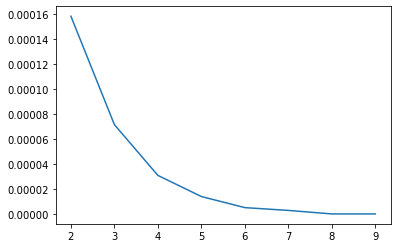

In [58]:
from sklearn.cluster import KMeans
wics,K = [],[i for i in range(2,10)]
for k in K:
    km  = KMeans(n_clusters = k,init = 'k-means++')
    km.fit(venues_grouped)
    wics.append(km.inertia_)
import seaborn as sns
sns.lineplot(x=K,y=wics)

The optimum number of clusters was found to be 4, since the slope changes suddenly at that point.

In [59]:
km  = KMeans(n_clusters = 4,init = 'k-means++')
km.fit(venues_grouped)
venues_grouped['label'] = km.labels_
venues_grouped

,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit,label
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0
"Alderwood, Long Branch",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0
"Bathurst Manor, Wilson Heights, Downsview North",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0
Bayview Village,0.001021,0.000408,0.000715,0.008782,0.000306,0.000204,0.000817,0.000408,0.000306,0.000102,...,0.002451,0.000102,0.001838,0.001838,0.001430,0.000817,0.005208,0.000613,0.002247,3
"Bedford Park, Lawrence Manor East",0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale West",0.000693,0.000416,0.000971,0.009015,0.000277,0.000277,0.000416,0.000555,0.000139,0.000000,...,0.003051,0.000139,0.002497,0.001526,0.001110,0.001110,0.005409,0.000555,0.002913,1
Woburn,0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0
Woodbine Heights,0.000983,0.000393,0.000688,0.008849,0.000393,0.000197,0.000787,0.000393,0.000393,0.000098,...,0.002360,0.000098,0.001770,0.001868,0.001376,0.000787,0.005211,0.000590,0.002163,0


In [60]:
toronto['cluster_label'] = 0
for nei,i in zip(toronto['Neighbourhood'],toronto.index):
    toronto.loc[i,'cluster_label'] = venues_grouped.loc[nei,'label']

In [61]:
toronto

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
0,M3A,North York,Parkwoods,43.761124,-79.324059,0
1,M4A,North York,Victoria Village,43.732658,-79.311189,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.716516,-79.442261,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.653482,-79.383935,0
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0
99,M4Y,Downtown Toronto,Church and Wellesley,43.662693,-79.386875,0
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,0


We will visualize all the cluster using folium.

In [62]:
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[43.70011, -79.4163], zoom_start=11)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto['Latitude'],toronto['Longitude'], toronto['Neighbourhood'], toronto['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
toronto[toronto['cluster_label']==0]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
0,M3A,North York,Parkwoods,43.761124,-79.324059,0
1,M4A,North York,Victoria Village,43.732658,-79.311189,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.716516,-79.442261,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.653482,-79.383935,0
...,...,...,...,...,...,...
97,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,0
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0
99,M4Y,Downtown Toronto,Church and Wellesley,43.662693,-79.386875,0
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0


In [64]:
toronto[toronto['cluster_label']==1]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
59,M2N,North York,"Willowdale, Willowdale East",43.77398,-79.413833,1
72,M2R,North York,"Willowdale, Willowdale West",43.77398,-79.413833,1


In [65]:
toronto[toronto['cluster_label']==2]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
89,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,2
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.668027,-79.369282,2
102,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,2


In [66]:
toronto[toronto['cluster_label']==3]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,cluster_label
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,3
39,M2K,North York,Bayview Village,43.769197,-79.376662,3
57,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,3
